In [484]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing_utils import *

In [485]:
# Parameters
start="1998-01-01"
end="2007-12-31"

TRAIN_PATH = "../data/pickle/df_stations_all_nonzero_extended.pkl"

st = (import_dataframe(TRAIN_PATH)
    .pipe(drop_df_NaNs, series='Prec') # Drop NaNs
    .pipe(clip_time_period, start, end) # Clip data temporally 
)

Length of imported dataframe: 364772
Length of dataframe after dropping NaNs: 364771
Length of clipped dataframe: 196997


In [486]:
st_pivot = st.pivot(index='Date',
        columns='Station',
        values='Prec')

In [487]:
st_corr = st_pivot.corr(method='spearman')

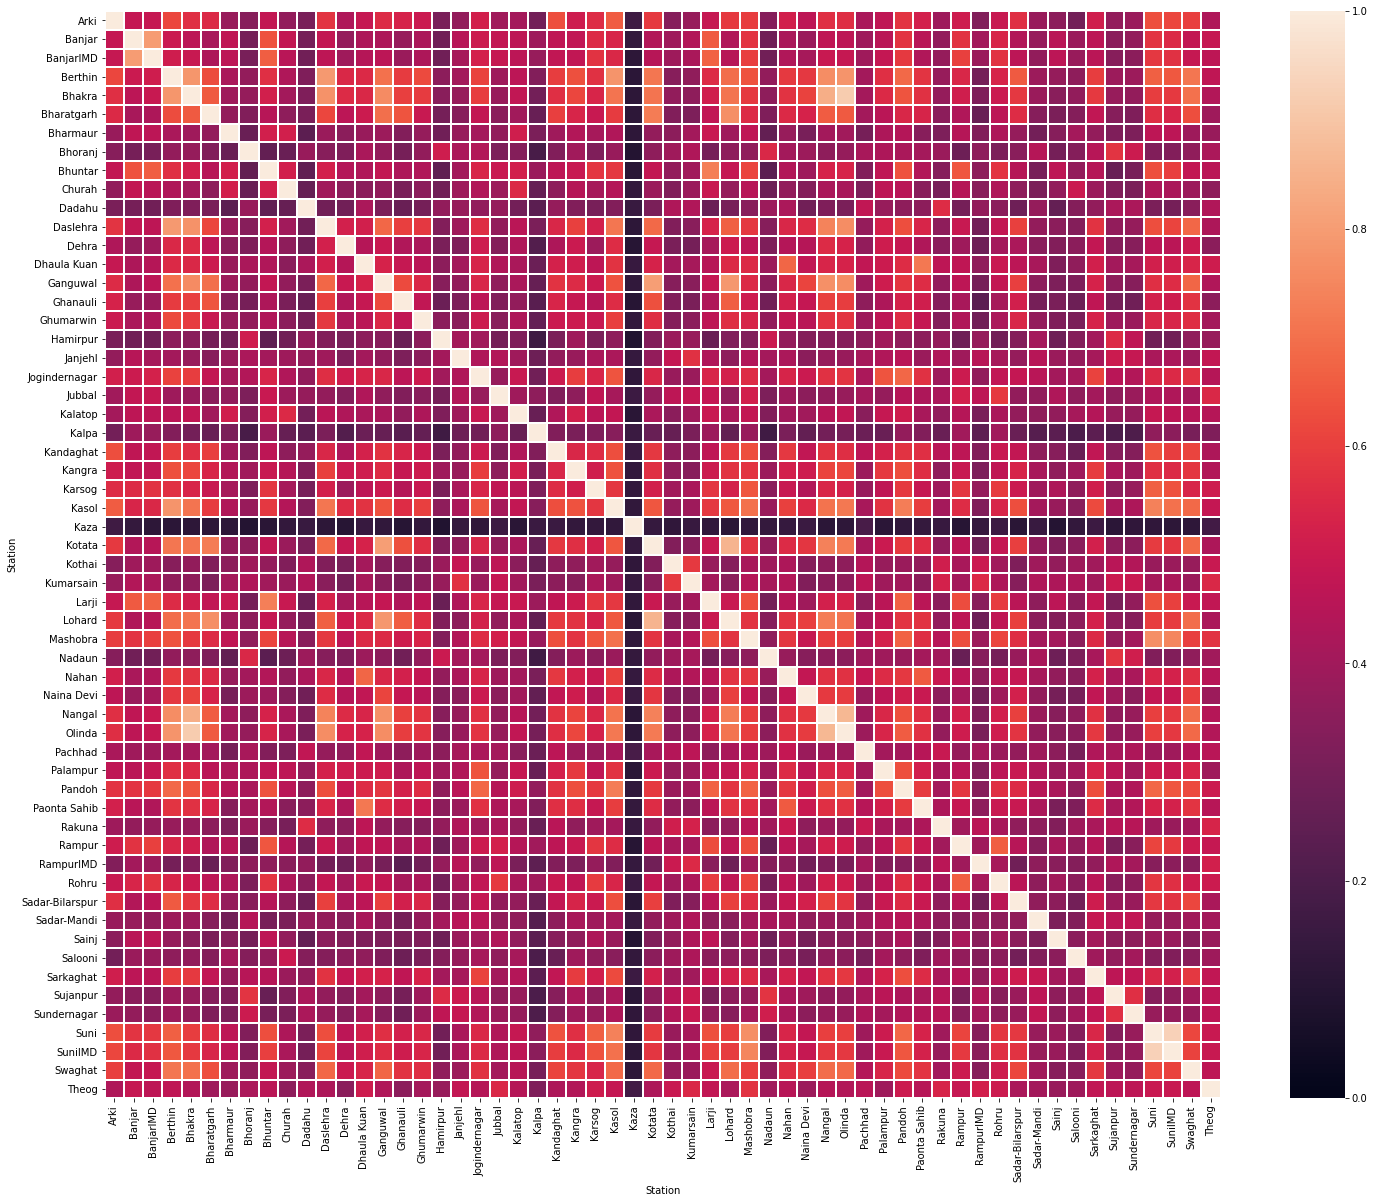

In [488]:
fig, ax = plt.subplots(figsize=(25,20))

sns.heatmap(st_corr,
            ax=ax,
            #annot=True,
            linewidths=0.4,
            #cmap='viridis', 
            #annot_kws={'size': 10},
            vmin=0,vmax=1)

plt.xticks(rotation=90);
plt.yticks(rotation=0);

plt.savefig('figures/corr-heatmap.png')

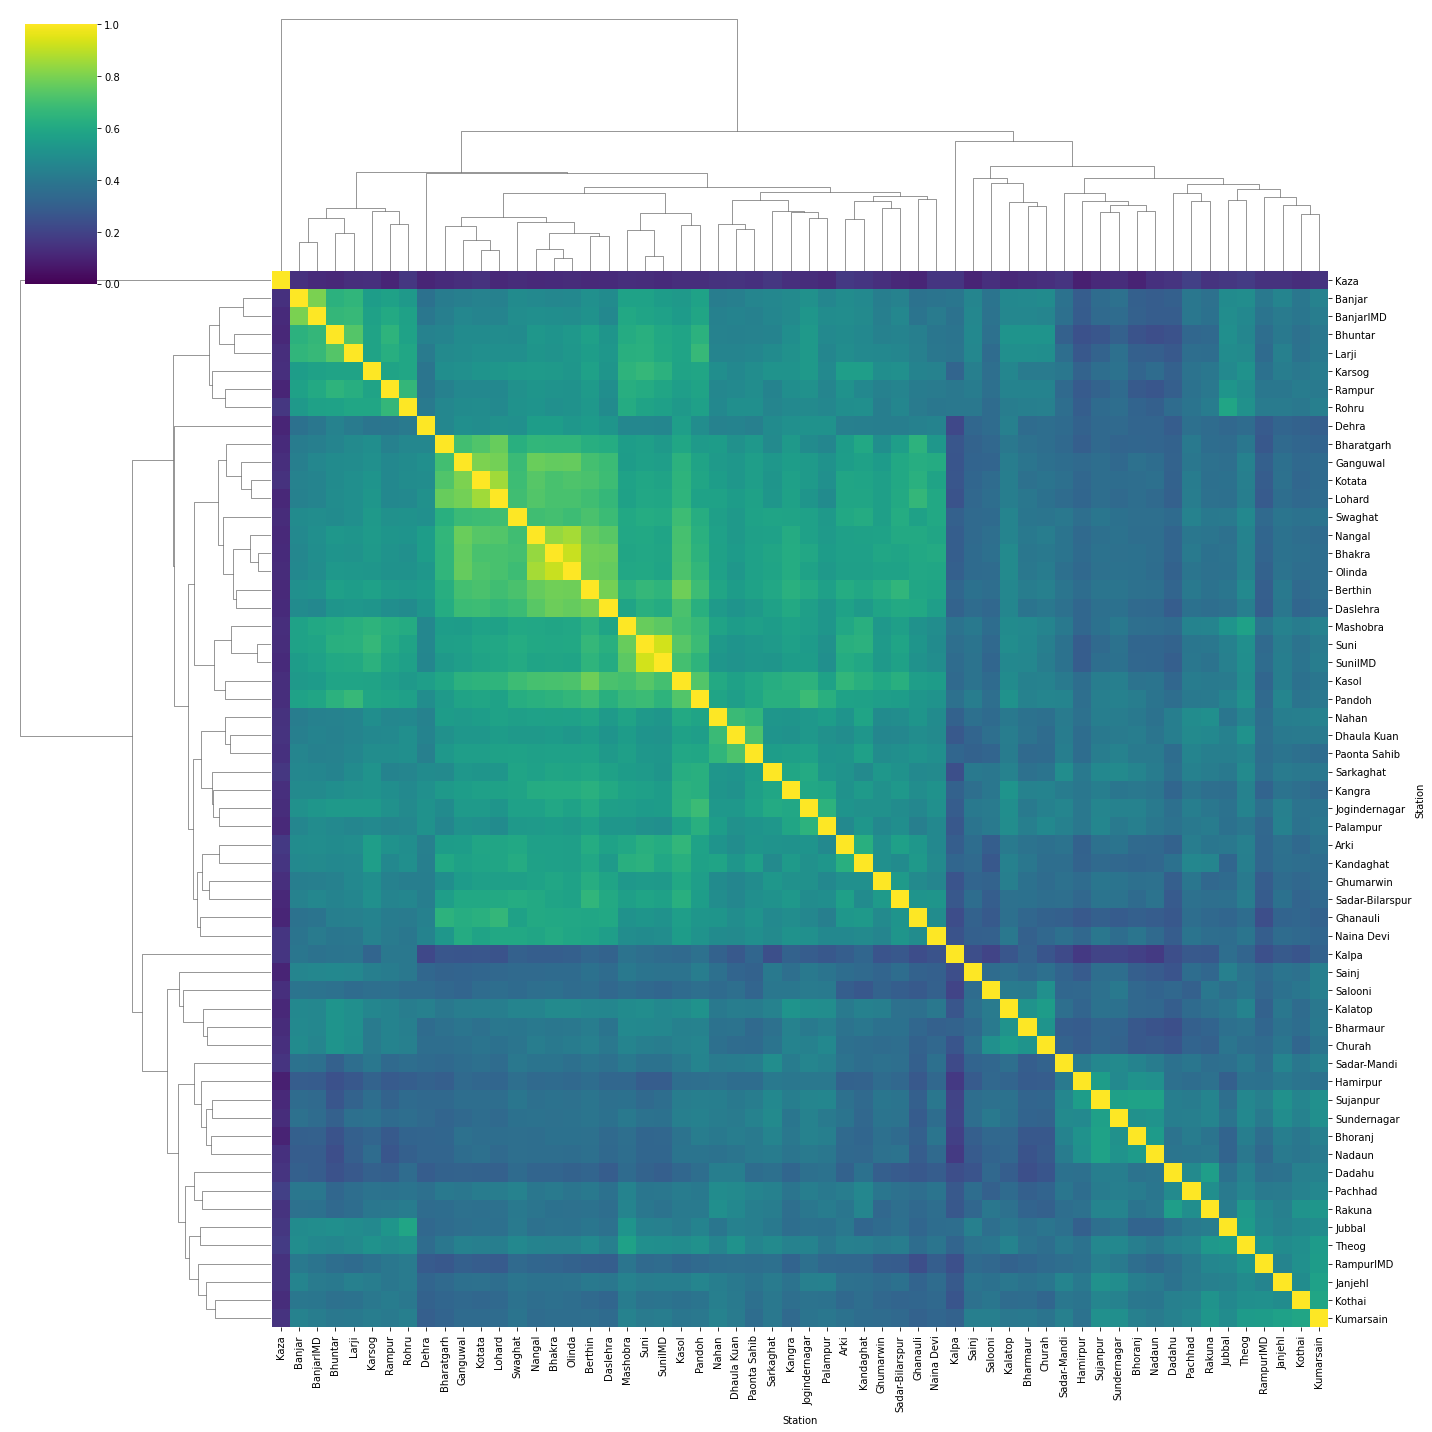

In [493]:
fig = sns.clustermap(st_corr,
               row_cluster=True,
               col_cluster=True,
               figsize=(20, 20),
               cmap='viridis',
               vmin=0,vmax=1,center=0.5
                    );

In [478]:
from scipy.spatial.distance import cdist

st_coords = st.groupby(by=['Station']).mean()[['Z']]

st_dist = pd.DataFrame(cdist(st_coords, st_coords, 'euclid'),index=st_coords.index,columns=st_coords.index)

st_dist = st_dist.reset_index()
st_dist = st_dist.rename(columns={'Station':'S1'})
st_dist = st_dist.melt(id_vars=['S1'],value_name='dist').rename(columns={'Station':'S2'})

st_dist_corr = st_corr.reset_index()
st_dist_corr = st_dist_corr.rename(columns={'Station':'S1'})
st_dist_corr = st_dist_corr.melt(id_vars='S1',value_name='corr').rename(columns={'Station':'S2'})

df = st_dist.merge(st_dist_corr, on=['S1','S2'])

st_basin = st.groupby(['Station','Basin']).mean().reset_index()[['Station','Basin']]

df = df.merge(st_basin, left_on='S1', right_on='Station').rename(columns={'Basin':'B1'}).merge(st_basin, left_on='S2', right_on='Station').rename(columns={'Basin':'B2'})

mask = df['B1'] == df['B2']

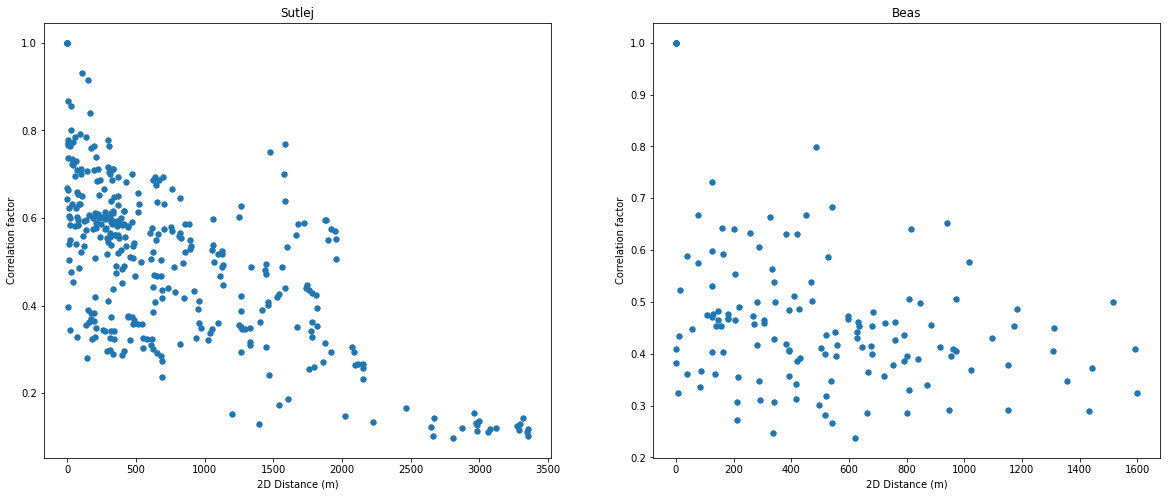

In [479]:
fig,axes = plt.subplots(1,2,figsize=(20,8))
for index, ax in enumerate(axes.flatten()):
    b = df[mask]['B1'].unique()[index]
    x = df['dist'][mask][df['B1']==b]
    y = df['corr'][mask][df['B1']==b]
    ax.plot(x,y,'o',markersize=5)
    ax.set_title(b)
    ax.set_xlabel('2D Distance (m)')
    ax.set_ylabel('Correlation factor')
plt.savefig('figures/corr-by-distZ.png',dpi=300)
plt.show()

### Timeseries

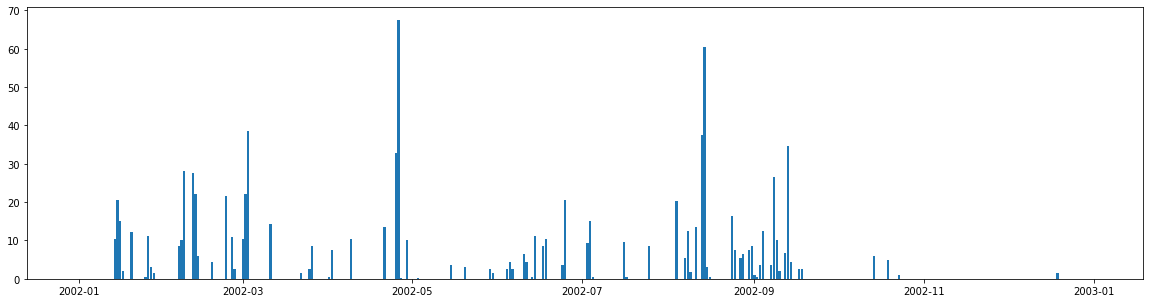

In [494]:
station = st['Station'].unique()[1]
df_station = st[st['Station']==station]
df_station.set_index('Date', inplace=True)

start = '2002-01-01'
end = '2002-12-31'
data = df_station.loc[start:end]
data.reset_index(inplace=True)

fig = plt.subplots(figsize=(20,5))
plt.bar(data['Date'], data['Prec'])
plt.show()

In [522]:
df_station['year'] = df_station.index.year
df_station['month'] = df_station.index.month

<ipython-input-522-310a0326ae0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station['year'] = df_station.index.year
<ipython-input-522-310a0326ae0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station['month'] = df_station.index.month


### ECDF

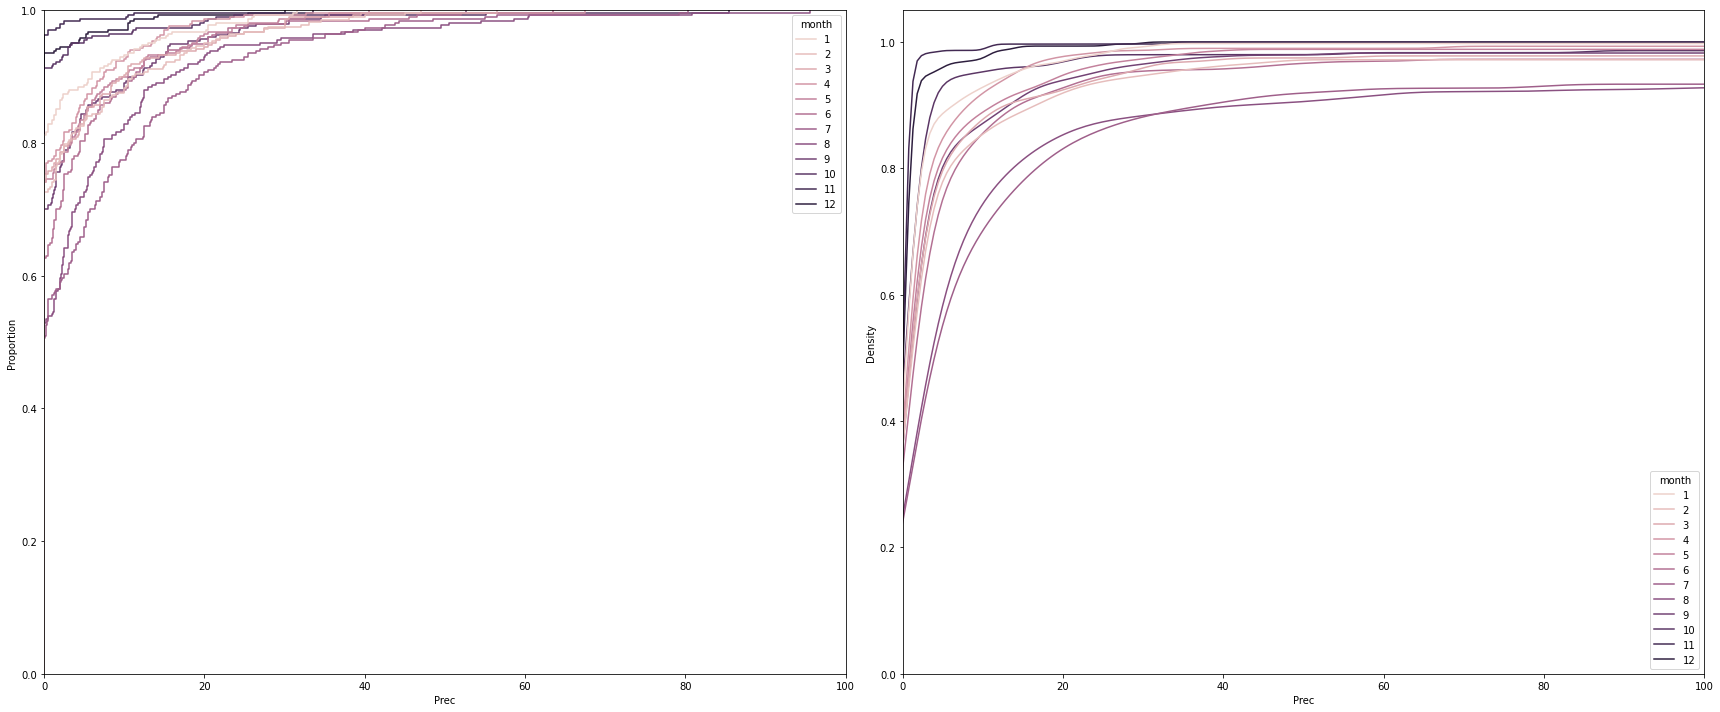

In [593]:
fig, axes = plt.subplots(1,2,figsize=(24,10))

ax = axes[0]
sns.ecdfplot(data=df_station, x='Prec', hue='month', ax=ax)

ax.set_xlim(0,100)

ax = axes[1]
sns.kdeplot(
    data=df_station, x="Prec", hue="month",
    cumulative=True, common_norm=False, common_grid=True, ax=ax)

ax.set_xlim(0,100)

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Prec', ylabel='Density'>

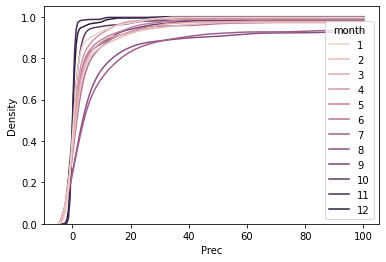

In [578]:
sns.kdeplot(
    data=df_station, x="Prec", hue="month",
    cumulative=True, common_norm=False, common_grid=True,
)

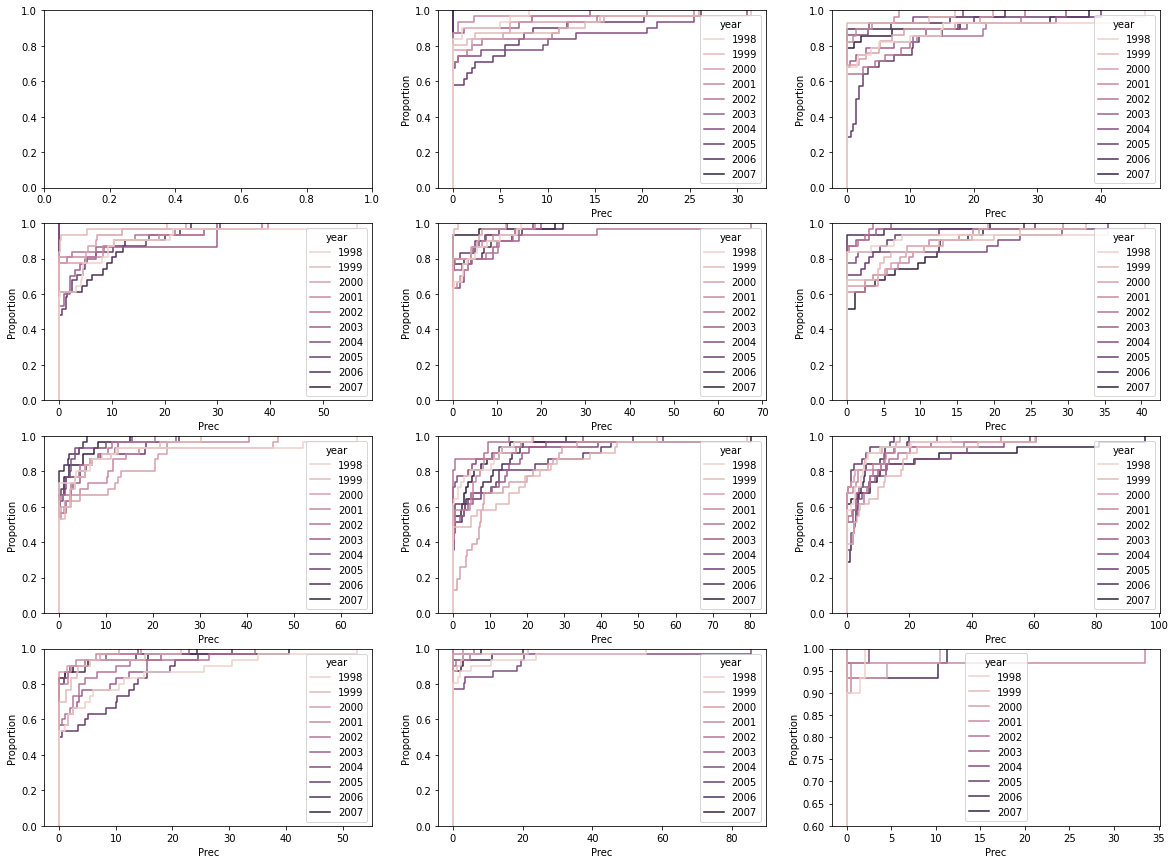

In [561]:
fig, axes = plt.subplots(4,3,figsize=(20,15))
for m, ax in enumerate(axes.flatten()):
    df2 = df_station[df_station['month']==m]    
    if len(df2)>0:
        sns.ecdfplot(data=df2, x="Prec", hue='year', ax=ax)
        plt.ylim(0.6,1)
        #ax.hist(x, bins=100, cumulative=True, density=True, histtype='step')
        #plt.xlim(0,data['Prec'].max())
plt.show()

<AxesSubplot:xlabel='Prec', ylabel='Proportion'>

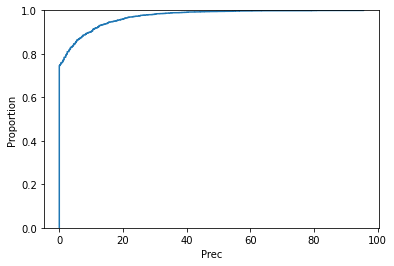